## 9.1 Examining the SARIMAX model

The SARIMAX model further extends the SARIMA(p,d,q)(P,D,Q)m model by adding the effect of exogenous variables. Therefore, we can express the present value $y_t$ simply as a SARIMA(p,d,q)(P,D,Q)m model to which we add any number of exogenous variables $X_t$ as shown in equation
<br/>
<center>\[y_t = SARIMA(p,d,q)(P,D,Q)_m + \sum_{i=1}^{n} \beta_i X^i_t \]</center>

The SARIMA model is a linear model, as it is a linear combination of past values of the series and error terms. Here we add another linear combination of different exogenous variables, resulting in SARIMAX being a linear model as well. Note that in SARIMAX you can include categorical variables as exogenous variables, but make sure you encode them (give them numerical values or binary flags) just like you would do for traditional regression tasks.

We have been using the SARIMAX function from statsmodels since chapter 4 to implement different models. This is because SARIMAX is the most general function for forecasting a time series. You now understand how a SARIMAX model without exogenous variables is a SARIMA model. Similarly, a model with no seasonality but with exogenous variables can be denoted as an ARIMAX model, and a model with no seasonality and no exogenous variables becomes an ARIMA model. Depending on the problem, different combinations of each portion of the general SARIMAX model will be used.

### 9.1.1 Exploring the exogenous variables of the US macroeconomics dataset

Let’s load the US macroeconomics dataset and explore the different exogenous variables available to us to forecast the real GDP. This dataset is available with the statsmodels library, meaning that you do not need to download and read an external file. You can load the dataset using the datasets module of statsmodels.

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


This displays the entire DataFrame containing the US macroeconomics dataset.

We have our target variable, or endogenous variable, which is the real GDP. Then we have 11 exogenous variables that can be used for forecasting, such as personal and federal consumption expenditures, interest rate, inflation rate, population, and others.

Of course, each of these variables may or may not be a good predictor of the real GDP. We do not have to perform feature selection because the linear model will attribute a coefficient close to 0 for exogenous variables that are not significant in predicting the target.

For the sake of simplicity and clarity, we will only work with six variables in this chapter: the real GDP, which is our target, and the next five variables (realcons to cpi) as our exogenous variables.

We can visualize how each variable behaves through time to see if we can discern any distinctive patterns.

In [2]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

NameError: name 'plt' is not defined

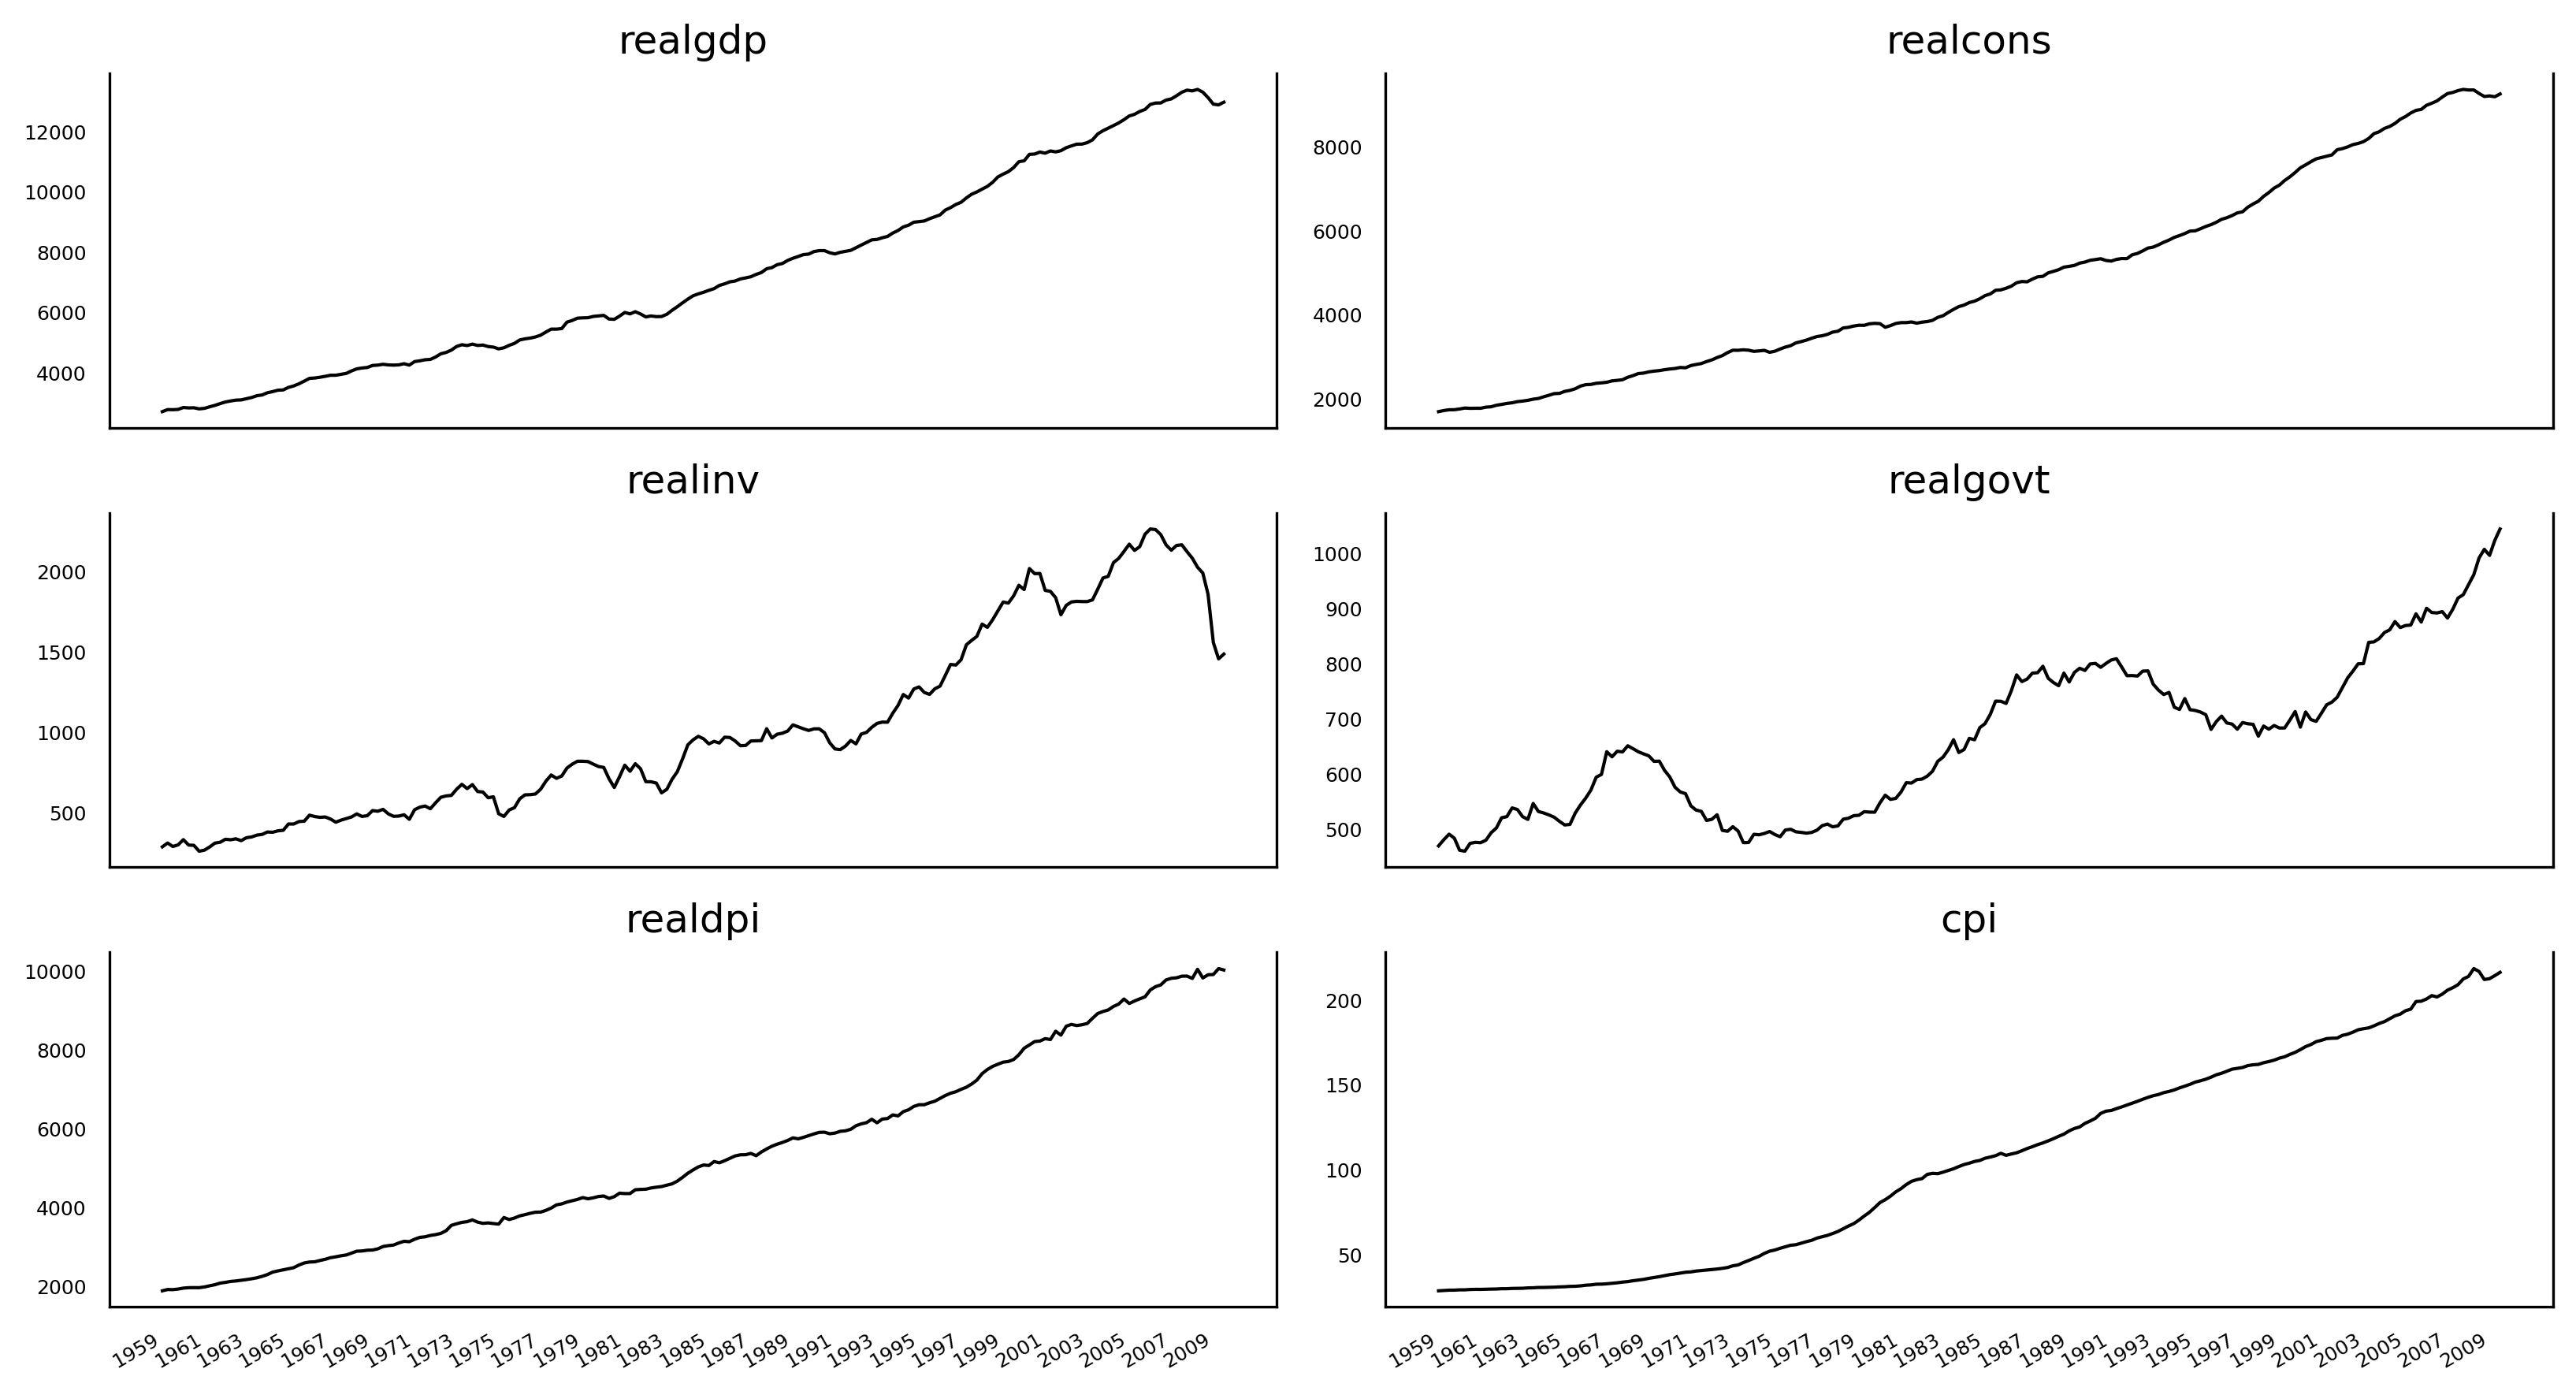

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

There are two ways to work with exogenous variables for time series forecasting. First, we could train multiple models with various combinations of exogenous variables, and see which model generates the best forecasts. Alternatively, we can simply include all exogenous variables and stick to model selection using the AIC, as we know this yields a good-fitting model that does not overfit.

### 9.1.2 Caveat for using SARIMAX

There is an important caveat that comes with the use of the SARIMAX model. Including external variables can potentially be beneficial, as you may find strong predictors for your target. However, you might encounter issues when forecasting multiple timesteps into the future.

Recall that the SARIMAX model uses the SARIMA(p,d,q)(P,D,Q)m model and a linear combination of exogenous variables to predict one timestep into the future. But what if you wish to predict two timesteps into the future? While this is possible with a SARIMA model, the SARIMAX model requires us to forecast the exogenous variables too. To illustrate this idea, let’s assume that realcons is a predictor of realgdp (this will be verified later in the chapter). Assume also that we have a SARIMAX model where realcons is used as an input feature to predict realgdp. Now suppose that we are at the end of 2009 and must predict the real GDP for 2010 and 2011. The SARIMAX model allows us to use the realcons of 2009 to predict the real GDP for 2010. However, predicting the real GDP for 2011 will require us to predict realcons for 2010, unless we wait to observe the value at the end of 2010.

Because the realcons variable is a time series itself, it can be forecast using a version of the SARIMA model. Nevertheless, we know that our forecast always has some error associated with it. Therefore, having to forecast an exogenous variable to forecast our target variable can magnify the prediction error of our target, meaning that our predictions can quickly degrade as we predict more timesteps into the future.

The only way to avoid that situation is to predict only one timestep into the future and wait to observe the exogenous variable before predicting the target for another timestep into the future. On the other hand, if your exogenous variable is easy to predict, meaning that it follows a known function that can be accurately predicted, there is no harm in forecasting the exogenous variable and using these forecasts to predict the target.

In the end, there is no clear recommendation to predict only one timestep. It is dependent on the situation and the exogenous variables available. This is where your expertise as a data scientist and rigorous experimenting come into play. If you determine that your exogenous variable can be accurately predicted, you can recommend forecasting many timesteps into the future. Otherwise, your recommendation must be to predict one timestep at a time and justify your decision by explaining that errors will accumulate as more predictions are made, meaning that the forecasts will lose accuracy.

Now that we have explored the SARIMAX model in depth, let’s apply it to forecast the real GDP.

## 9.2 Forecasting the real GDP using the SARIMAX model

We are now ready to use the SARIMAX model to forecast the real GDP. Having explored the exogenous variables of the dataset, we will incorporate them into our forecasting model.

Before diving in, we must reintroduce the general modeling procedure. There are no major changes to the procedure. The only modification is that we will now fit a SARIMAX model.
<br/>
<center><img src="" /></center>

In [5]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647144
p-value: 0.9982455372335032


This returns an ADF statistic of 1.75 and a p-value of 1.00. Since the ADF statistic is not a large negative number, and the p-value is larger than 0.05, we cannot reject the null hypothesis and conclude that the series is not stationary.

Therefore, we must apply a transformation and test for stationarity again. Here we will difference the series once:

In [6]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


This now returns an ADF statistic of –6.31 and p-value of 3.32 × 10–8. With a large negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis and conclude that the series is now stationary. Therefore, we know that d = 1. Since we did not need to take a seasonal difference to make the series stationary, D = 0.

We will now define the optimize_SARIMAX function, which will fit all unique combinations of the model and return a DataFrame in ascending order of AIC.

In [7]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Next we’ll define the range of possible values for the orders p, q, P, and Q. We’ll try values from 0 to 3, but feel free to try a different set of values. Also, since the data is collected quarterly, m = 4.

In [8]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

To train the model, we will use the first 200 instances of both the target and exogenous variables. We’ll then run the optimize_SARIMAX function and select the model with the lowest AIC.

In [9]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824160
1,"(3, 3, 1, 0)",1744.966657
2,"(3, 3, 0, 1)",1744.996891
3,"(2, 2, 0, 0)",1745.472424
4,"(2, 2, 0, 1)",1746.163408
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


Once it’s completed, the function returns the verdict that the SARIMAX(3,1,3)(0,0,0)4 model is the model with the lowest AIC. Notice that the seasonal component of the model has only orders of 0. This makes sense, as there is no visible seasonal pattern in the plot of real GDP, as shown in figure 9.4. Therefore, the seasonal component is null, and we have an ARIMAX(3,1,3) model.

Now we can fit the selected model and display a summary table to see the coefficients associated with our exogenous variables.

In [10]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Tue, 20 Sep 2022   AIC                           1742.824
Time:                        18:41:56   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9707      0.045     21.515      0.000       0.882       1.059
realinv        1.0132      0.033     30.702      0.000       0.949       1.078
realgovt       0.7281      0.127      5.728      0.0

You’ll notice that all exogenous variables have a p-value smaller than 0.05, except for realdpi, which has a p-value of 0.712. This means that the coefficient of realdpi is not significantly different from 0. You’ll also notice that its coefficient is 0.0091. However, the coefficient is kept in the model, as the p-value does not determine the relevance of this predictor in forecasting our target.

Moving on with the modeling procedure, we’ll now study the residuals of the model. Everything points to the residuals being completely random, just like white noise. Our model passes the visual check.

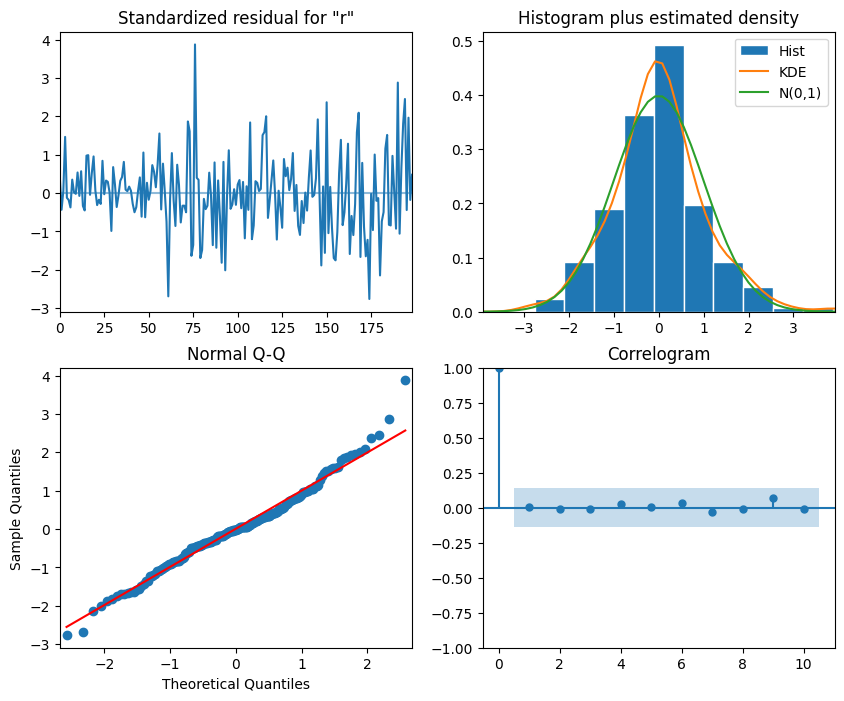

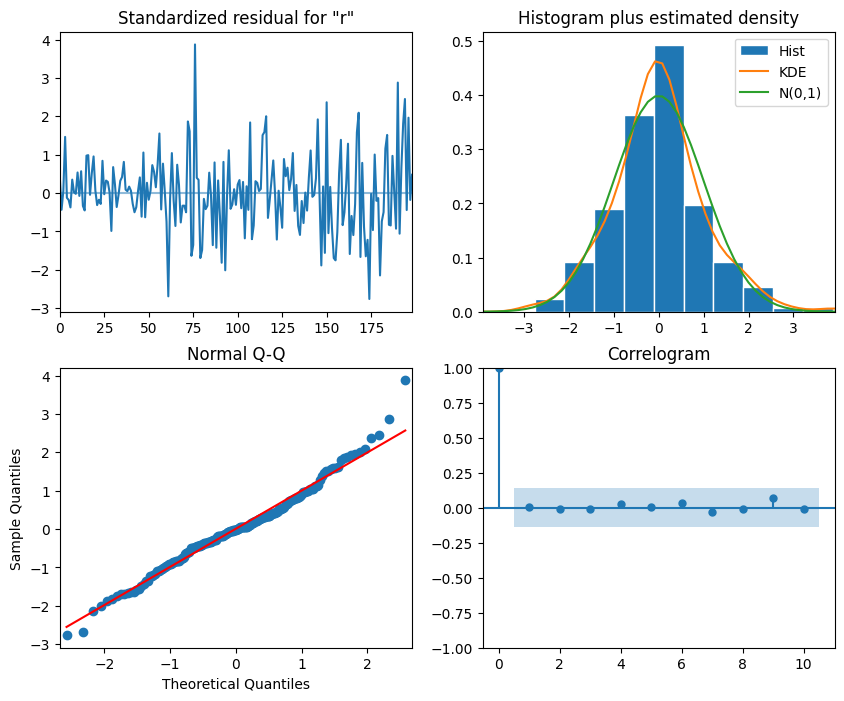

In [11]:
best_model_fit.plot_diagnostics(figsize=(10,8))

Now we’ll apply the Ljung-Box test to make sure the residuals are not correlated. We therefore want to see p-values that are greater than 0.05, since the null hypothesis of the Ljung-Box test is that residuals are independent and uncorrelated.

In [12]:
residuals = best_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.092672   0.760807
2   0.199557   0.905038
3   0.201648   0.977323
4   1.255646   0.868855
5   1.256463   0.939347
6   1.283478   0.972561
7   1.475588   0.983143
8   1.485587   0.992945
9   1.857244   0.993529
10  1.863859   0.997281


All the p-values are greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated. Having passed both residual checks, our model can be used for forecasting.

As mentioned before, the caveat of using a SARIMAX model is that it is reasonable to predict only the next timestep, to avoid predicting the exogenous variables as well, which would lead us to accumulate prediction errors in the final forecast.

Instead, to test our model, we predict the next timestep multiple times and average the errors of each prediction. This is done using the rolling_forecast function, which we defined and worked with in chapters 4–6. As a baseline model, we will use the last known value method.

In [13]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

The recursive_forecast function allows us to predict the next timestep over a certain period of time. Specifically, we will use it to forecast the next timestep starting in 2008 and going to the third quarter of 2009.

In [14]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df


,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.061637
197,13415.266,13366.865,13373.515326
198,13324.600,13415.266,13378.804886
199,13141.920,13324.600,13327.766113
200,12925.410,13141.920,13133.243212
201,12901.504,12925.410,12886.655196
202,12990.341,12901.504,12873.790647


With the predictions done, we can visualize which model has the lowest mean absolute percentage error (MAPE).

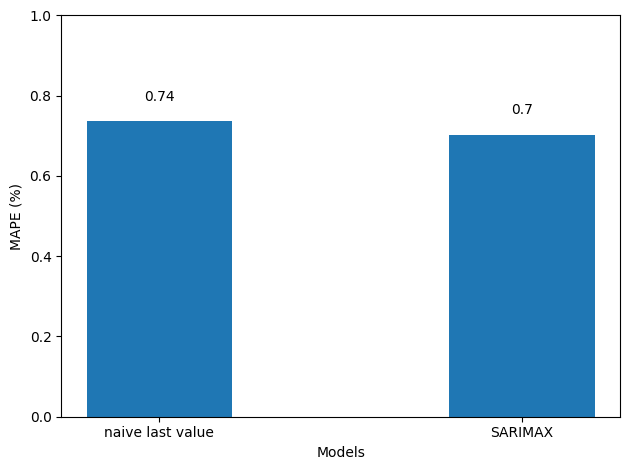

In [15]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
plt.tight_layout()